In [1]:
from sklearn.decomposition import PCA, TruncatedSVD
from scipy import sparse
import pickle
import pandas as pd
import numpy as np

from Constants import *

### Load data
We the TF-IDF matrices and the corresponding indexes previously created.

In [2]:
newspaper_speaker_tfidf = sparse.load_npz(FILE_NEWSPAPER_SPEAKER_TFIDF)
newspaper_speaker_tfidf = newspaper_speaker_tfidf.toarray()

newspaper_token_tfidf = sparse.load_npz(FILE_NEWSPAPER_TOKEN_TFIDF)
newspaper_token_tfidf = newspaper_token_tfidf.toarray()

In [3]:
with open(PICKLE_NEWSPAPER_TO_INDEX, 'rb') as handle:
    newspaper_to_index = pickle.load(handle)

with open(PICKLE_INDEX_TO_NEWSPAPER, 'rb') as handle:
    index_to_newspaper = pickle.load(handle)
    
    
with open(PICKLE_SPEAKER_TO_INDEX, 'rb') as handle:
    speaker_to_index = pickle.load(handle)

with open(PICKLE_INDEX_TO_SPEAKER, 'rb') as handle:
    index_to_speaker = pickle.load(handle)
    
    
with open(PICKLE_INDEX_TO_TOKEN, 'rb') as handle:
    index_to_token = pickle.load(handle)

with open(PICKLE_TOKEN_TO_INDEX, 'rb') as handle:
    token_to_index = pickle.load(handle)
    
newspaper_infos = pd.read_csv(FILE_NEWSPAPER_INFOS)

In [4]:
print(f"newspaper_speaker_tfidf shape: {newspaper_speaker_tfidf.shape}")
print(f"newspaper_token_tfidf shape: {newspaper_token_tfidf.shape}")
print(f"newspaper_to_index length: {len(newspaper_to_index)}")
print(f"index_to_newspaper length: {len(index_to_newspaper)}")
print(f"speaker_to_index length: {len(speaker_to_index)}")
print(f"index_to_speaker length: {len(index_to_speaker)}")
print(f"index_to_token length: {len(index_to_token)}")
print(f"token_to_index length: {len(token_to_index)}")

newspaper_speaker_tfidf shape: (7362, 212145)
newspaper_token_tfidf shape: (7362, 262208)
newspaper_to_index length: 7362
index_to_newspaper length: 7362
speaker_to_index length: 212145
index_to_speaker length: 212145
index_to_token length: 262208
token_to_index length: 262208


### Detailed map using bokeh plot
Create a 2D scatter plot using bokeh:
* Each newspaper is represented using a dot on the map.  
* The color of the points is defined by their owner group.  
* Hovering a dot give information about the newspaper.
* Selecting a newspaper will directly open his webpage in a new tab.
* Hide/show newspapers owned by a group by selecting the group in the legend. By default the 10 most clustered groups are shown.
* The broadcast group are displayed ordered by their mean distance of the newspaper to the group center.

In [5]:
import bokeh
import bokeh.plotting as bpl
from bokeh.plotting import figure, output_file, show, save
from bokeh.palettes import Turbo256, Plasma, cividis, magma
from bokeh.models import LabelSet,Scatter,HoverTool, WheelZoomTool, PanTool, BoxZoomTool, ResetTool, TapTool, SaveTool, OpenURL
from bokeh.models.callbacks import CustomJS
from bokeh.transform import factor_cmap

def get_mean_distance_to_center(Y, owners):
    """
    Compute the mean absolute distance of the newspaper of each group to the center of the group (in 2D).
    Y: np.array(num_newspaper, 2) location of the newspaper in a 2D space.
    owners: Corresponding owners.
    """
    
    df = pd.DataFrame(
        {
            "x": Y[:, 0],
            "y": Y[:, 1],
            "group": owners
        }
    )
    
    mean_per_group = df.groupby("group").mean()
    df = df.join(mean_per_group,on ="group", rsuffix="_mean")
    df["diff"] = np.abs(df["x"] - df["x_mean"]) + np.abs(df["y"] - df["y_mean"])
    return df.groupby("group")["diff"].mean().sort_values()

def plot_scatter_bokeh(Y, newspaper_in_group, visible_by_default = False):
    """
    Create a 2D map of the newspapers.
    """
    df = pd.DataFrame(
        {
            "x": Y[:, 0],
            "y": Y[:, 1],
            "group": newspaper_in_group.owner,
            "newspaper": newspaper_in_group.newspaper,
            "country": newspaper_in_group.country,
            "region": newspaper_in_group.region,
            "QID": newspaper_in_group.QID,
        }
    )
    
    df.loc[:, df.columns != 'group'] = df.loc[:, df.columns != 'group'].fillna("-")

    # Compute clustering index
    group_mean_distance = get_mean_distance_to_center(Y, newspaper_in_group.owner)
    group_cluster_ranking = list(group_mean_distance[group_mean_distance.notna()].index)
    
    df['group'] = pd.Categorical(df['group'], categories=group_cluster_ranking, ordered=True)
        
    top_culster_group = group_cluster_ranking[:10]

    # Show info on hover
    hover = HoverTool(tooltips=[('Newspaper', '@newspaper'),('Owner', '@group'),('Country', '@country'),('Region', '@region'),('QID', '@QID')])
    tools = [hover, WheelZoomTool(), PanTool(), BoxZoomTool(), ResetTool(), SaveTool(), TapTool()]

    groups = df['group'].unique()
    color_map = factor_cmap("group", factors=sorted(groups),palette=magma(len(groups)))

    # create figure and plot
    p = bpl.figure(height=1000, width=1500, tools=tools)

    for group_name,points in df.groupby('group'):
        
        if len(points) != 0:

            source = bpl.ColumnDataSource(points)
            
            # Display ranking clustering with groupe name
            label_name = f"{group_cluster_ranking.index(group_name):<2} - {group_name}" 
            
            # Display newspaper
            scat = p.scatter(x='x', y='y',
                      fill_color= color_map,
                      line_color = color_map,
                      legend_label=label_name, source=source)

            if not visible_by_default:
                scat.visible = group_name in top_culster_group
            else:
                scat.visible = True


            # Open website on click on newspaper dot
            source.selected.js_on_change('indices', CustomJS(args=dict(s1=source), code="""
                const inds = cb_obj.indices;
                for (var i = 0; i < inds.length; i++) {
                    var ind = inds[i]
                    var url = 'https://www.wikidata.org/wiki/'+s1.data['QID'][ind]
                    window.open(url)
            }
                """)
            )
            
    # Show newspaper of the group when clic on the legend
    p.legend.click_policy="hide"

    # Define legend size
    p.legend.label_text_font_size = '16px'
    #Padding on the overall rectangle
    p.legend.padding = 0
    p.legend.spacing = 0
    #Size of circular points
    p.legend.glyph_height = 16
    p.legend.glyph_width = 16
    #Padding between label entries
    p.legend.label_height = 0
    p.legend.label_width = 0
    
    # Generate the graph
    bpl.show(p)
    return p

### Select newspaper that are owned by a group with multiple newspaper
We keep only the newspapers for which we identified an owner that owns at least X other newspapers.

In [6]:
#Minimum number of newspaper needed in a group to consider that group
MIN_NEWSPAPER_COUNT = 4

# Remove newspaper without identified owner
newspaper_with_owner = newspaper_infos[newspaper_infos["owner"].notnull()]
print(f'We have identified the owner of the newspaper for {len(newspaper_with_owner) / len(newspaper_infos) * 100}% of the data.')

# Remove newspaper with less than MIN_NEWSPAPER_COUNT - 1 other newspapers owned by the same group 
num_np_by_owner = newspaper_with_owner.groupby("owner").count()["newspaper"]
group_owner = set(num_np_by_owner[num_np_by_owner >= MIN_NEWSPAPER_COUNT].index)
newspaper_in_group = newspaper_with_owner[newspaper_with_owner["owner"].isin(group_owner)].copy()

print(f"Newspapers owned by a group owning at least {MIN_NEWSPAPER_COUNT-1} other newspapers represent {len(newspaper_in_group) / len(newspaper_with_owner) * 100}% of the newspapers with identified owner.")

# Add an ID to the owner
newspaper_in_group['owner'] = pd.Categorical(newspaper_in_group.owner)
newspaper_in_group['owner_ID'] = newspaper_in_group['owner'].cat.codes

print(f'We obtain {newspaper_in_group["owner"].nunique()} different groups.')

newspaper_in_group

We have identified the owner of the newspaper for 13.61043194784026% of the data.
Newspapers owned by a group owning at least 3 other newspapers represent 41.91616766467065% of the newspapers with identified owner.
We obtain 46 different groups.


,newspaper,QID,website,owner,country,region,latitude,longitude,owner_ID
2,1045theteam,Q7956286,http://www.1045theteam.com,Townsquare Media,United States of America,New York,42.879000,-73.863000,38
4,107jamz,Q6331512,http://www.107jamz.com,Townsquare Media,United States of America,Louisiana,30.202000,-92.947000,38
5,10news,Q3191396,http://www.10news.com/,E. W. Scripps Company,United States of America,San Diego,32.838889,-117.248889,10
8,13abc,Q2386816,http://www.13abc.com/,Gray Television,United States of America,Toledo,41.651824,-83.642371,18
16,247sports,Q16973497,https://247sports.com/,ViacomCBS Streaming,NaN,NaN,NaN,NaN,41
...,...,...,...,...,...,...,...,...,...
7269,www,Q150248,https://www.metacritic.com/,ViacomCBS Streaming,NaN,NaN,NaN,NaN,41
7285,wxyz,Q3564870,http://www.wxyz.com/,E. W. Scripps Company,United States of America,Detroit,42.471521,-83.246925,10
7293,wyrk,Q7958139,http://www.wyrk.com,Townsquare Media,United States of America,New York,42.886000,-78.873000,38
7310,yardbarker,Q8049272,http://www.yardbarker.com/,Fox Entertainment Group,NaN,San Francisco,NaN,NaN,12


In [7]:
newspaper_USA = newspaper_in_group[newspaper_in_group["country"] == "United States of America"]

MIN_NEWSPAPER_COUNT = 3

# Remove newspaper with less than MIN_NEWSPAPER_COUNT - 1 other newspapers owned by the same group 
num_np_by_owner = newspaper_USA.groupby("owner").count()["newspaper"]
group_owner = set(num_np_by_owner[num_np_by_owner >= MIN_NEWSPAPER_COUNT].index)
newspaper_in_group_USA = newspaper_USA[newspaper_USA["owner"].isin(group_owner)].copy()

print(f"Number of group in USA with {MIN_NEWSPAPER_COUNT} newspaper: {newspaper_in_group_USA['owner'].nunique()}")
print(f"Representing {len(newspaper_in_group_USA)/len(newspaper_in_group)*100}% of the newspaper in group")
newspaper_in_group_USA

Number of group in USA with 3 newspaper: 23
Representing 43.095238095238095% of the newspaper in group


,newspaper,QID,website,owner,country,region,latitude,longitude,owner_ID
2,1045theteam,Q7956286,http://www.1045theteam.com,Townsquare Media,United States of America,New York,42.879000,-73.863000,38
4,107jamz,Q6331512,http://www.107jamz.com,Townsquare Media,United States of America,Louisiana,30.202000,-92.947000,38
5,10news,Q3191396,http://www.10news.com/,E. W. Scripps Company,United States of America,San Diego,32.838889,-117.248889,10
8,13abc,Q2386816,http://www.13abc.com/,Gray Television,United States of America,Toledo,41.651824,-83.642371,18
41,700wlw,Q1698486,https://700wlw.iheart.com,iHeartMedia,United States of America,Cincinnati,39.353111,-84.325111,45
...,...,...,...,...,...,...,...,...,...
7217,wsaz,Q7955485,http://www.wsaz.com/,Gray Television,United States of America,Huntington,38.510083,-82.219306,18
7218,wsbradio,Q7955527,http://wsbradio.com,Cox Enterprises,United States of America,Atlanta,33.843889,-84.253333,6
7231,wtam,Q3564801,http://www.wtam.com/,iHeartMedia,United States of America,Cleveland,41.280600,-81.622800,45
7285,wxyz,Q3564870,http://www.wxyz.com/,E. W. Scripps Company,United States of America,Detroit,42.471521,-83.246925,10


### SVD decomposition of the TF-IDF matrices and axes exploration
Using SVD, we project the newspapers along the axes with the higher variance. Exploring the revelance of the speakers/tokens toward each axis give insight on the meaning of the axis.

In [8]:
import scipy
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt

In [9]:
def project_SVD(selected_newspapers, newspaper_to_index, X, dim=2):
    """
    Create a SVD decomposition of the selected_newspaper in X.
    
    selected_newspapers: List of selected newspaperps
    newspaper_to_index: mapping from newspaper name to row index in the matrix
    X: newspaper representation in high dimension
    dim: number of axes after projection
    
    return the projection of the selected newspaper and the revelance of each axis toward the other dimension of X
    """
    
    newspaper_in_group_idx = [newspaper_to_index[newspaper] for newspaper in selected_newspapers]
    selected_X = X[newspaper_in_group_idx]
    
    #Same as TruncatedSVD
    U, sigmas, VT = randomized_svd(selected_X, n_components=dim)
    
    X_red = U@np.diag(sigmas)
    
    return X_red, VT

def get_top_axis(VT,index_map,top_num=5):
    
    for i in range(VT.shape[0]):
        sord_idx = np.argsort(VT[i])
        top_min_idx = sord_idx[:top_num]
        top_max_idx = sord_idx[::-1][:top_num]
        
        print(f'\nThe top {top_num} max values for axis {i} are:')
        for index in top_max_idx:
            print(f'{index_map[index]:<30} {VT[i,index]:.4f}')
        
        print(f'\nThe top {top_num} min values for axis {i} are:')
        for index in top_min_idx:
            print(f'{index_map[index]:<30} {VT[i,index]:.4f}')
            
        print("\n")
        
def plot_axes(X_red, newspaper_in_group):
    """
    Plot the projected data in 2D with all combination of the different axes
    """
    num_axis = X_red.shape[1]
    fig = plt.figure(figsize=(15, 15))

    count = 1
    for i in range(num_axis):
        for j in range(num_axis):
            if i<j:
                fig.add_subplot(num_axis, num_axis, count)
                plt.scatter(X_red[:,i], X_red[:,j], c=newspaper_in_group.owner_ID)
                plt.title(f"Axis {i} - {j}")
                count+=1

    fig.tight_layout()

### Speaker analysis

#### Speaker main axes identification

In [10]:
num_axis_speaker = 5
X_red_speaker, VT_speaker = project_SVD(newspaper_in_group['newspaper'], newspaper_to_index, newspaper_speaker_tfidf,dim=num_axis_speaker)
get_top_axis(VT_speaker,index_to_speaker,top_num=10)


The top 10 max values for axis 0 are:
president donald trump         0.3809
boris johnson                  0.3502
matt hancock                   0.2453
jose mourinho                  0.1696
nicola sturgeon                0.1390
pep guardiola                  0.1381
rishi sunak                    0.1328
tedros adhanom ghebreyesus     0.1295
leo varadkar                   0.1273
frank lampard                  0.1232

The top 10 min values for axis 0 are:
 palmer                        -0.0000
 rowdy  roddy piper            -0.0000
 superstar  billy graham       -0.0000
 yoshida                       -0.0000
justin gamble                  0.0000
marc horowitz                  0.0000
marc huber                     0.0000
marc humbert                   0.0000
marc j cohen                   0.0000
marc janssen                   0.0000



The top 10 max values for axis 1 are:
president donald trump         0.5393
joe biden                      0.2080
bernie sanders                 0.1765
and

##### Speaker clustering analysis

Based on the top speakers per axes, we identified the following axes:

Axis 0:
- Max: Frequent speakers
- Min: Non frequent speakers (rare)

Axis 1:
- Max: US speakers
- Min: UK speakers

Axis 2:
- Max: Australian speakers
- Min: US speakers

Axis 3:
- Max: Canadian speakers
- Min: US politicians speakers

Axis 4:
- Max: Basketball speakers
- Min: US politicians speakers

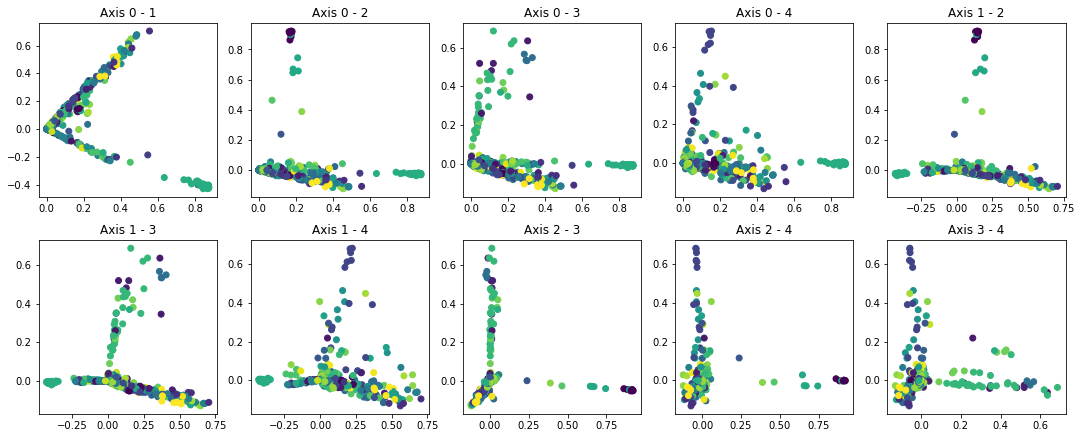

In [11]:
plot_axes(X_red_speaker, newspaper_in_group)

In [19]:
AXIS_1 = 0
AXIS_2 = 1

p = plot_scatter_bokeh(X_red_speaker[:,[AXIS_1,AXIS_2]],newspaper_in_group)
output_file(PLOT_FOLDER + f'newspaper_speaker_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

'/Users/Antoine/Documents/EPFL/MA1/ADA/ada-2021-project-mahj/plot/newspaper_speaker_axis_0_1.html'

As we can see, the speakers are very different in newspapers from diverse countries which results in clustering only based on the country of origin of newspapers. For media groups such as News Corp Australia, it is already a  very good way to differentiate it from the other groups.  
We might now ask ourselves if it is possible to differentiate media groups of the same country. We will use the USA to answer this question.

#### USA speaker  clustering analysis

In [13]:
num_axis_speaker_USA = 5
X_red_speaker_USA, VT_speaker_USA = project_SVD(newspaper_in_group_USA['newspaper'], newspaper_to_index, newspaper_speaker_tfidf,dim=num_axis_speaker_USA)
get_top_axis(VT_speaker_USA, index_to_speaker,top_num=10)


The top 10 max values for axis 0 are:
president donald trump         0.6641
joe biden                      0.2556
bernie sanders                 0.2231
anthony fauci                  0.2016
andrew cuomo                   0.1966
nancy pelosi                   0.1485
elizabeth warren               0.1472
gavin newsom                   0.1471
tedros adhanom ghebreyesus     0.1355
pete buttigieg                 0.1235

The top 10 min values for axis 0 are:
 mad mike                      -0.0000
 palmer                        -0.0000
 sandy  alex g                 -0.0000
 rowdy  roddy piper            -0.0000
 the franchise  shane douglas  -0.0000
 yoshida                       -0.0000
 the fox                       -0.0000
justin gamble                  -0.0000
maurice wade                   -0.0000
maurice tucker                 -0.0000



The top 10 max values for axis 1 are:
gavin newsom                   0.3953
frank vogel                    0.2539
dave roberts                   0.19

Based on the top token per axes, we identified the following axes:

**Axis 0**: Same as before
- Max: Frequent speakers
- Min: Non frequent speakers (rare)

**Axis 1**:
- Max: Sport/politic celebrity of Los Angeles
- Min: TODO

**Axis 2**:
- Max: TODO
- Min: TODO

**Axis 3**:
- Max: TODO
- Min: TODO

**Axis 4**:
- Max: TODO
- Min: TODO

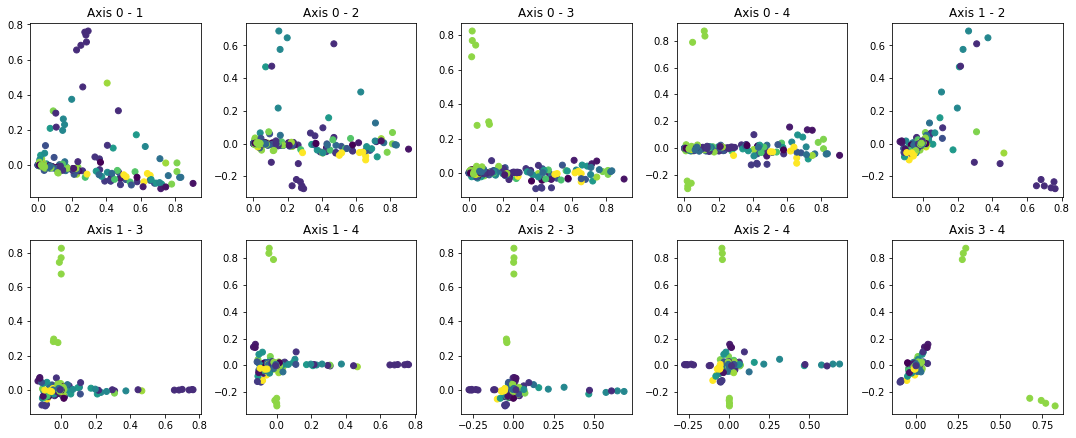

In [15]:
plot_axes(X_red_speaker_USA, newspaper_in_group_USA)

In [ ]:
AXIS_1 = 3
AXIS_2 = 4

p = plot_scatter_bokeh(X_red_speaker_USA[:,[AXIS_1,AXIS_2]],newspaper_in_group_USA)
output_file(PLOT_FOLDER + f'newspaper_speaker_USA_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

Once again, Townsquare Media is monopolising the secondary axes with its local radio stations BLABLABLA

##### USA speakers clustering analysis without Townsquare Media

In [16]:
selected_newspaper_USA = newspaper_in_group_USA[newspaper_in_group_USA["owner"] != "Townsquare Media"]
num_axis_speaker_USA_selec = 5
X_speaker_USA_selec, VT_speaker_USA_selec = project_SVD(selected_newspaper_USA['newspaper'], newspaper_to_index, newspaper_speaker_tfidf, dim=num_axis_speaker_USA_selec)
get_top_axis(VT_speaker_USA_selec, index_to_speaker, top_num=15)


The top 15 max values for axis 0 are:
president donald trump         0.6641
joe biden                      0.2564
bernie sanders                 0.2238
anthony fauci                  0.2019
andrew cuomo                   0.1959
nancy pelosi                   0.1483
gavin newsom                   0.1478
elizabeth warren               0.1476
tedros adhanom ghebreyesus     0.1357
pete buttigieg                 0.1238
amy klobuchar                  0.1151
adam schiff                    0.1139
mitch mcconnell                0.1054
chuck schumer                  0.0969
mike pompeo                    0.0884

The top 15 min values for axis 0 are:
 lane                          -0.0000
 hang                          -0.0000
 mad mike                      -0.0000
 sandy  alex g                 -0.0000
 rowdy  roddy piper            -0.0000
 the fox                       -0.0000
justin gamble                  -0.0000
mauro esposito                 -0.0000
mauro forghieri                -0.0000
m

Based on the top token per axes, we identified the following axes:

**Axis 0, 1, 2**: TODO

**Axis 3**: TODO

**Axis 4**:
- Max: TODO 
- Min: TODO

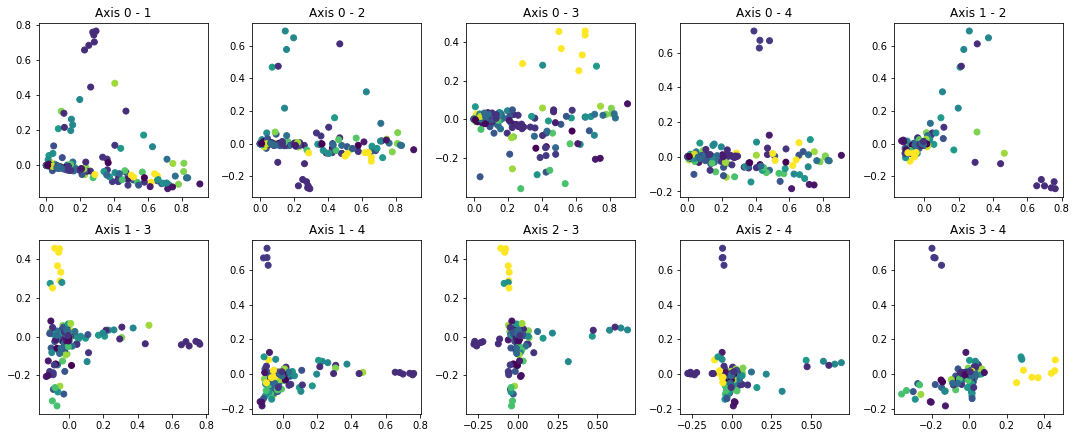

In [17]:
plot_axes(X_speaker_USA_selec, selected_newspaper_USA)

In [18]:
AXIS_1 = 3
AXIS_2 = 4

p = plot_scatter_bokeh(X_speaker_USA_selec[:,[AXIS_1,AXIS_2]],selected_newspaper_USA)
output_file(PLOT_FOLDER + f'selec_newspaper_token_USA_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

'/Users/Antoine/Documents/EPFL/MA1/ADA/ada-2021-project-mahj/plot/selec_newspaper_token_USA_axis_3_4.html'

### Token analysis

#### Token main axes identification

In [12]:
num_axis_token = 5
X_red_token, VT_token = project_SVD(newspaper_in_group['newspaper'], newspaper_to_index, newspaper_token_tfidf, dim=num_axis_token)
get_top_axis(VT_token, index_to_token, top_num=10)


The top 10 max values for axis 0 are:
people                         0.2289
going                          0.1894
get                            0.1778
time                           0.1730
like                           0.1615
think                          0.1614
one                            0.1443
would                          0.1341
know                           0.1321
really                         0.1315

The top 10 min values for axis 0 are:
AAAAA                          -0.0000
AAAAHHHH                       -0.0000
AAAM                           -0.0000
ﹾC                             0.0000
Nursultan                      0.0000
Nurture                        0.0000
NurtureCloud                   0.0000
golem                          0.0000
goldspot                       0.0000
Nurul                          0.0000



The top 10 max values for axis 1 are:
game                           0.3144
player                         0.2493
play                           0.1854
team

##### Tokens clustering analysis

Based on the top token per axes, we identified the following axes:

Axis 0:
- Max: Frequent words
- Min: Non frequent words

Axis 1:
- Max: Sport
- Min: US health

Axis 2:
- Max: UK sport/politic
- Min: Music/Joy: garbage

Axis 3:
- Max: Music
- Min: Sport

Axis 4:
- Max: Canada
- Min: US/UK : garbage

Axis 18:
Interessant

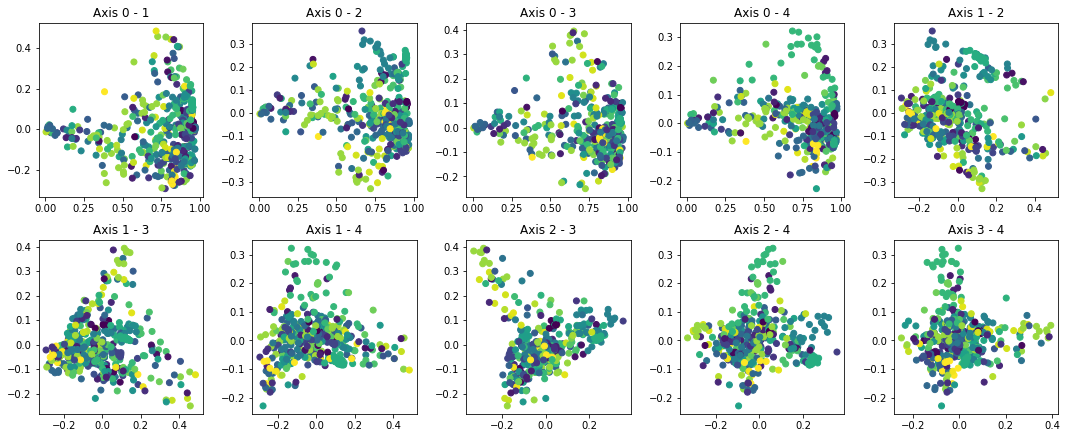

In [13]:
plot_axes(X_red_token, newspaper_in_group)

In [ ]:
AXIS_1 = 0
AXIS_2 = 1

p = plot_scatter_bokeh(X_red_token[:,[AXIS_1,AXIS_2]],newspaper_in_group)
output_file(PLOT_FOLDER + f'newspaper_token_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

#### USA Tokens clustering analysis

In [16]:
num_axis_token_USA = 5
X_red_token_USA, VT_token_USA = project_SVD(newspaper_in_group_USA['newspaper'], newspaper_to_index, newspaper_token_tfidf, dim=num_axis_token_USA)
get_top_axis(VT_token_USA, index_to_token, top_num=15)


The top 15 max values for axis 0 are:
people                         0.2368
going                          0.2076
get                            0.1791
like                           0.1687
time                           0.1677
think                          0.1571
one                            0.1437
know                           0.1409
would                          0.1294
really                         0.1284
want                           0.1283
need                           0.1242
thing                          0.1226
year                           0.1187
make                           0.1156

The top 15 min values for axis 0 are:
AAAAAA                         -0.0000
AAAAAAA                        -0.0000
AAAI                           -0.0000
AAAAHHHH                       -0.0000
AAAS                           -0.0000
AAAM                           -0.0000
AAAP                           -0.0000
organazing                     -0.0000
organelle                      -0.0000
S

Based on the top token per axes, we identified the following axes:

**Axis 0**:
- Max: Frequent words
- Min: Non frequent words

**Axis 1**:
- Max: Sport
- Min: Public health

**Axis 2**:
- Max: Music
- Min: Sport

**Axis 3**:
- Max: Local / State related
- Min: Country wide / President

**Axis 4**:
- Max: ~Montana state
- Min: ~Louisiana 

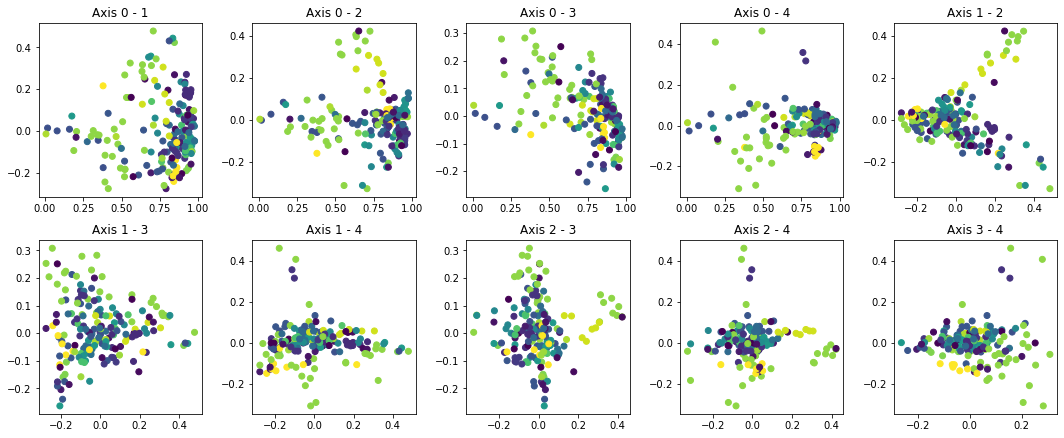

In [17]:
plot_axes(X_red_token_USA, newspaper_in_group_USA)

In [ ]:
AXIS_1 = 0
AXIS_2 = 5

p = plot_scatter_bokeh(X_red_token_USA[:,[AXIS_1,AXIS_2]],newspaper_in_group_USA, True)
output_file(PLOT_FOLDER + f'newspaper_token_USA_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

Once again, Townsquare Media is monopolising the secondary axes with its local radio stations. We remove them in order to analyse the rest of the newspapers.

##### USA Tokens clustering analysis without Townsquare Media

In [65]:
selected_newspaper_USA = newspaper_in_group_USA[newspaper_in_group_USA["owner"] != "Townsquare Media"]

In [66]:
num_axis_token_USA_selec = 5
X_token_USA_selec, VT_token_USA_selec = project_SVD(selected_newspaper_USA['newspaper'], newspaper_to_index, newspaper_token_tfidf, dim=num_axis_token_USA_selec)
get_top_axis(VT_token_USA_selec, index_to_token, top_num=15)


The top 15 max values for axis 0 are:
people                         0.2417
going                          0.2106
get                            0.1795
like                           0.1667
time                           0.1650
think                          0.1613
one                            0.1431
know                           0.1413
would                          0.1309
want                           0.1298
really                         0.1290
need                           0.1251
thing                          0.1234
make                           0.1162
year                           0.1161

The top 15 min values for axis 0 are:
AAAAA                          -0.0000
AAAS                           -0.0000
AAAI                           -0.0000
AAAM                           -0.0000
AAAP                           -0.0000
ﹾC                             -0.0000
overcorrecting                 -0.0000
SquareFoot                     -0.0000
SquareOneMJ                    -0.0000
o

Based on the top token per axes, we identified the following axes:

**Axis 0, 1, 2**: same as above

**Axis 3**: same as before but less directly related to a particular state

**Axis 4**:
- Max: Election 
- Min: Covid

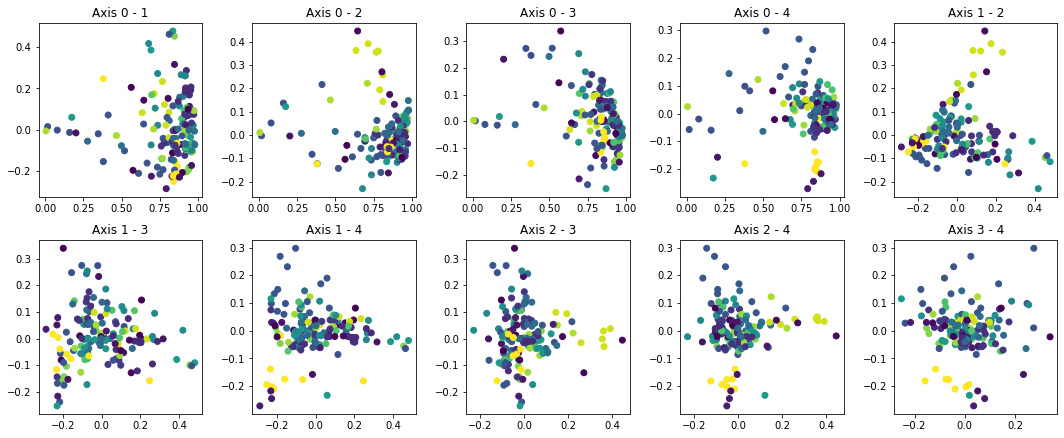

In [67]:
plot_axes(X_token_USA_selec, selected_newspaper_USA)

In [80]:
AXIS_1 = 3
AXIS_2 = 4

p = plot_scatter_bokeh(X_token_USA_selec[:,[AXIS_1,AXIS_2]],selected_newspaper_USA)
output_file(PLOT_FOLDER + f'selec_newspaper_token_USA_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

'/Users/jonas/Desktop/EPFL/Ma1/ADA/ada-2021-project-mahj/plot/selec_newspaper_token_USA_axis_3_4.html'